### Synthesis of circuits generated by diagonal operators (within DBQAs algorithms)

In [46]:
import numpy as np
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt

# using pytorch
import torch
import qiboml.interfaces.pytorch as pt

from qibo.hamiltonians import XXZ
from qibo import set_backend
from qiboml.models.ansatze import HardwareEfficient
from qiboml.models.decoding import Expectation
from boostvqe.models.dbi.double_bracket_evolution_oracles import XXZ_EvolutionOracle

In [47]:
set_backend("qiboml", platform="pytorch")

[Qibo 0.2.20|INFO|2025-06-24 14:13:58]: Using qiboml (pytorch) backend on cpu


In [109]:
nqubits = 6
nlayers = 4
dt = 0.1
epochs = 500
nruns = 5

delta = 0.5

losses, vqe_circuits = [], []
for k in range(nruns):
    print(f"\n--------- Executing training {k+1}/{nruns} ------------ ")
    
    circuit = HardwareEfficient(nqubits, nlayers=nlayers)
    hamiltonian = XXZ(nqubits, delta=delta)
    ground_energy = np.min(np.asarray(hamiltonian.eigenvalues()))
    decoding = Expectation(nqubits, observable=hamiltonian)
    
    pt_model = pt.QuantumModel(circuit_structure=[circuit,], decoding=decoding)
    optimizer = torch.optim.Adam(pt_model.parameters(), lr=0.1)
    these_losses = []
    for iteration in range(epochs):
        optimizer.zero_grad()
        cost = pt_model()
        cost.backward()
        optimizer.step()
        these_losses.append(cost.item())
        if iteration % 100 == 0:
            print(f"Cost at epoch {iteration + 1}/{epochs} | {these_losses[-1]:.4}")
    losses.append(these_losses)

    # Save the trained circuit
    vqe_circuits.append(pt_model.circuit_structure[0])
    
median_losses = np.median(losses, axis=0)
mad_losses = median_abs_deviation(losses, axis=0)


--------- Executing training 1/5 ------------ 
Cost at epoch 1/500 | -0.2688
Cost at epoch 101/500 | -8.996
Cost at epoch 201/500 | -9.062
Cost at epoch 301/500 | -9.062
Cost at epoch 401/500 | -9.062

--------- Executing training 2/5 ------------ 
Cost at epoch 1/500 | 0.1499
Cost at epoch 101/500 | -8.622
Cost at epoch 201/500 | -8.766
Cost at epoch 301/500 | -8.769
Cost at epoch 401/500 | -8.77

--------- Executing training 3/5 ------------ 
Cost at epoch 1/500 | 0.1285
Cost at epoch 101/500 | -8.82
Cost at epoch 201/500 | -9.123
Cost at epoch 301/500 | -9.123
Cost at epoch 401/500 | -9.123

--------- Executing training 4/5 ------------ 
Cost at epoch 1/500 | -0.6046
Cost at epoch 101/500 | -8.565
Cost at epoch 201/500 | -8.625
Cost at epoch 301/500 | -8.765
Cost at epoch 401/500 | -8.877

--------- Executing training 5/5 ------------ 
Cost at epoch 1/500 | -0.3689
Cost at epoch 101/500 | -8.41
Cost at epoch 201/500 | -8.876
Cost at epoch 301/500 | -8.88
Cost at epoch 401/500 | -8.

In [138]:
def plot_loss(loss_values, loss_mads, ground_energy, after_dbqa=None):
    x = range(len(loss_values))
    plt.plot(x, loss_values, color="blue", label="VQE loss function")
    plt.fill_between(x, loss_values-loss_mads, loss_values+loss_mads, color="blue", alpha=0.3)
    plt.hlines(ground_energy, 0, len(loss_values), color="black", label="Target ground state energy")
    if after_dbqa is not None:
        plt.hlines(after_dbqa[0], 0, epochs, color='red', alpha=1, label='After one step of DBQA')
        plt.fill_between(
            x, 
            after_dbqa[0] - after_dbqa[1],
            after_dbqa[0] + after_dbqa[1],
            color='red',
            alpha=0.3,
        )
    plt.grid(True)
    plt.legend()
    plt.ylim(ground_energy-0.25, -8)

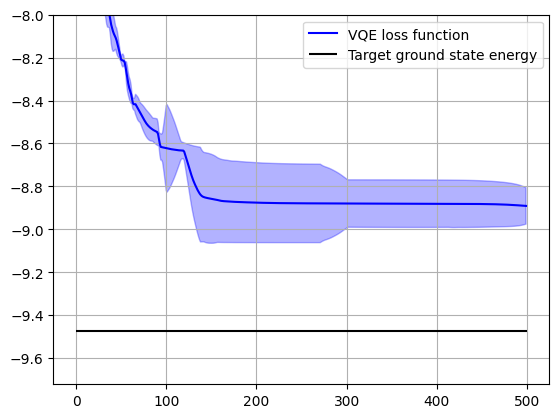

In [139]:
plot_loss(median_losses, mad_losses, ground_energy)

In [112]:
# The first piece of the circuit (an example)
vqe_circuits[0].draw()
print("\n", vqe_circuits[0].summary())

0: ─RY─RZ─o───────X─RY─RZ─o───────X─RY─RZ─o───────X─RY─RZ─o───────X─
1: ─RY─RZ─X─o─────|─RY─RZ─X─o─────|─RY─RZ─X─o─────|─RY─RZ─X─o─────|─
2: ─RY─RZ───X─o───|─RY─RZ───X─o───|─RY─RZ───X─o───|─RY─RZ───X─o───|─
3: ─RY─RZ─────X─o─|─RY─RZ─────X─o─|─RY─RZ─────X─o─|─RY─RZ─────X─o─|─
4: ─RY─RZ───────X─|─RY─RZ───────X─|─RY─RZ───────X─|─RY─RZ───────X─|─
5: ─RY─RZ─────────o─RY─RZ─────────o─RY─RZ─────────o─RY─RZ─────────o─

 Circuit depth = 18
Total number of gates = 68
Number of qubits = 6
Most common gates:
ry: 24
rz: 24
cx: 20


In [113]:
input_evolution = XXZ_EvolutionOracle.from_nqubits(
    nqubits=nqubits, delta=delta, steps=3, order=2
)

In [114]:
# XXZ input evolution
input_circuit = input_evolution.circuit(dt)
input_circuit.draw()

0:     ─RZ─────o─RY─────X─RY─────o───────X─────RZ─o────────X─────RZ─RZ─────o─ ...
1:     ────X───|─RZ─o───|────X───|─RZ─RZ─o─────RY─X─────RY─o───────────X───|─ ...
2:     ─RZ─o───|─RY─X───|─RY─o───|─────────X───RZ───o────────X───RZ─RZ─o───|─ ...
3:     ──────X─|─RZ───o─|──────X─|─RZ─RZ───o───RY───X───RY───o───────────X─|─ ...
4:     ─RZ───o─|─RY───X─|─RY───o─|───────────X─RZ─────o────────X─RZ─RZ───o─|─ ...
5:     ────────X─RZ─────o────────X─RZ─RZ─────o─RY─────X─RY─────o───────────X─ ...

0: ... RY─────X─RY─────o────
1: ... RZ─o───|────X───|─RZ─
2: ... RY─X───|─RY─o───|────
3: ... RZ───o─|──────X─|─RZ─
4: ... RY───X─|─RY───o─|────
5: ... RZ─────o────────X─RZ─


In [115]:
from pyexorcism.generation import (
    random_Z_boolean_function,
    z_terms_to_bool_func,
    boolean_function_to_pla,
)
from pyexorcism.optimization import SimpleExorcism
from pyexorcism.circuit import esop_to_qibo_circuit

In [141]:
# Generating a complicated generic Z-based function
nterms = 50
max_locality=nqubits

terms, func_string = random_Z_boolean_function(nqubits, nterms, max_locality=max_locality, seed=42)
print("Random Boolean function (in Zs):")
print(func_string)

# Convert the generated terms into a boolean function
bool_f = z_terms_to_bool_func(terms, nqubits)

# Convert it into PLA string
pla_string = boolean_function_to_pla(bool_f, nqubits)
print(pla_string)

# 3. Get PLA lines
pla_lines = pla_string.splitlines()

# 4. Run Exorcism minimization
exorcism = SimpleExorcism.from_pla(pla_lines)
minimized_cubes = exorcism.minimize()

print("\n\nMinimized cubes (ESOP):", minimized_cubes, "\n\n")

[INFO][SimpleExorcism] Starting minimization: 32 cubes
[INFO][SimpleExorcism] Merged 16 pairs at iteration 0
[INFO][SimpleExorcism] Merged 8 pairs at iteration 1
[INFO][SimpleExorcism] Minimization complete: 8 cubes remain (reduced by 24)


Random Boolean function (in Zs):
+1*Z3Z4Z5 -1*Z0Z2 +1*Z1 -1*Z0Z2Z3Z4 +1*Z2Z5 -1*Z2Z3 -1*Z1Z5 +1*Z0Z3 +1*Z0Z1Z3Z4Z5 +1*Z0Z1 +1*Z0Z1Z2Z5 -1*Z1Z3Z4Z5 +1*Z1Z3Z4 +1*Z5 +1*Z2Z3Z4 -1*Z0Z2Z5 -1*Z2 -1*Z0Z2Z3Z4Z5 -1*Z0Z2Z4Z5 +1*Z1Z4 -1*Z0Z1Z2Z3Z4 -1*Z1Z2Z4 +1*Z2Z3Z5 -1*Z0Z1Z3Z5 +1*Z1Z3Z5 +1*Z1Z3 +1*Z0Z3Z4Z5 +1*Z0Z2Z4 -1*Z0Z1Z2Z4 -1*Z0Z3Z4 -1*Z0Z1Z2Z4Z5 +1*Z0 -1*Z0Z1Z5 +1*Z0Z2Z3 +1*Z0Z1Z3Z4 +1*Z0Z1Z3 -1*Z1Z2Z3Z5 -1*Z0Z5 -1*Z2Z3Z4Z5 +1*Z4 +1*Z1Z2Z4Z5 -1*Z0Z3Z5 +1*Z3 -1*Z0Z1Z4Z5 -1*Z0Z2Z3Z5 -1*Z4Z5 +1*Z1Z2 -1*Z2Z4 +1*Z0Z4 +1*Z0Z1Z4
.i 6
.o 1
000000 0
000001 0
000010 1
000011 1
000100 0
000101 0
000110 1
000111 1
001000 1
001001 1
001010 0
001011 0
001100 1
001101 1
001110 0
001111 0
010000 1
010001 1
010010 0
010011 0
010100 1
010101 1
010110 0
010111 0
011000 0
011001 0
011010 1
011011 1
011100 0
011101 0
011110 1
011111 1
100000 1
100001 1
100010 0
100011 0
100100 1
100101 1
100110 0
100111 0
101000 0
101001 0
101010 1
101011 1
101100 0
101101 0
101110 1
101111 1
110000 0
110001 0
110010 1
110011

In [124]:
def cost_for_dt(vqe_circuit, cubes, nqubits, dt):
    """Compute cost function given cubes and dt."""
    diag_circuit = esop_to_qibo_circuit(cubes, nqubits, dt)
    full_circuit = diag_circuit + vqe_circuit + input_circuit + vqe_circuit.invert() + diag_circuit.invert() + vqe_circuit
    return hamiltonian.expectation(full_circuit().state())

def hyperopt_diagonal_circuit(vqe_circuit, nsamples, cubes, nqubits):
    """
    Simple grid optimization of the dt value for diagonal evolution generated after EXORCISM optimization.
    
    Returns:
        Optimization grid, all the computed cost function values and the best cost function value.
    """
    values = []
    grid = np.logspace(2, -4, nsamples)
    for value in grid:
        values.append(cost_for_dt(vqe_circuit, cubes, nqubits, value).detach().numpy())
    return grid, values, np.min(values)

In [127]:
# As an example
nsamples = 100

cost_values, best_values = [], []
for k in range(nruns):
    print(f"----- Hyperoptimizing diagonal evolution for VQE {k+1}/{nruns} ----- ")
    grid, cost_value, best_value = hyperopt_diagonal_circuit(
        vqe_circuit=vqe_circuits[k], nsamples=nsamples, cubes=minimized_cubes, nqubits=nqubits
    )
    cost_values.append(cost_value)
    best_values.append(best_value)

----- Hyperoptimizing diagonal evolution for VQE 1/5 ----- 
----- Hyperoptimizing diagonal evolution for VQE 2/5 ----- 
----- Hyperoptimizing diagonal evolution for VQE 3/5 ----- 
----- Hyperoptimizing diagonal evolution for VQE 4/5 ----- 
----- Hyperoptimizing diagonal evolution for VQE 5/5 ----- 


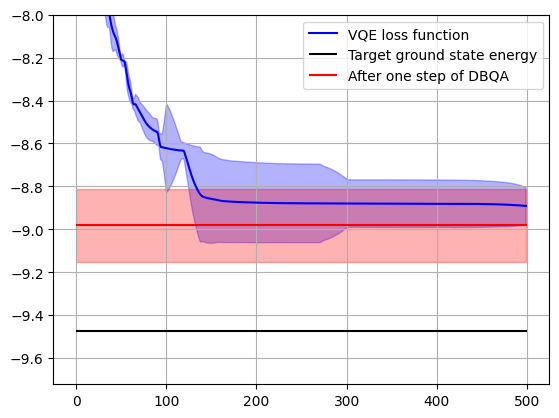

In [140]:
plot_loss(median_losses, mad_losses, ground_energy, after_dbqa=[np.median(best_values), median_abs_deviation(best_values)])